# JuliaでKeplerの法則のシミュレーション

具体的な数値計算は https://drive.google.com/file/d/1BJzy3BMRnBzB0bVKxcA0ucTAcTFmnn0r/view?usp=sharing で紹介したEuler法，Feynmanが自著で紹介した方法（Leap-frog法）と，Runge-Kutta法で行う．また，3法則が近似的に成り立つことも示す．

In [1]:
# パッケージをインポート
using Pkg
Pkg.add("Plots")
using Plots
using LinearAlgebra

   Resolving package versions...
  No Changes to `C:\Users\nnaot\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\nnaot\.julia\environments\v1.10\Manifest.toml`


## Euler法

初期条件を与えたらEuler法で計算してくれる関数を定義する．これは1次近似
$$\begin{aligned}
v(t+\Delta t)&=v(t)+a(t)\Delta t \\
r(t+\Delta t)&=r(t)+v(t)\Delta t
\end{aligned}$$
なので簡単である．

In [2]:
function Euler(r, v, Δt, i)              # 初期位置ベクトルr, 初速度ベクトルv, 時間幅Δt, 繰り返しi
    x = [r[1]]                           # x座標のリストを初期化
    y = [r[2]]                           # y座標のリストを初期化

    for _ in 1:i
        a = -r / norm(r) ^ 3                 # 運動方程式（GM = 1とした），norm(r)はrの原点からの距離
        v += a * Δt                        # 速度を一次近似，v(t+Δt) = v(t) + a(t) Δt
        r += v * Δt                        # 位置を一次近似，r(t+Δt) = r(t) + v(t) Δt

        push!(x, r[1])                   # x座標をリストに追加
        push!(y, r[2])                   # y座標をリストに追加
    end
    
    #プロットする．
    plot = scatter(x, y, 
    xlabel = "x", ylabel = "y",
    size = [750, 500], label = "Orbit",
    xlims = [-1.5, 1], ylims = [-1, 1],)
   
    scatter!(plot, [0], [0],
    marker = 10, label = "Focus")
    
    return plot
end

Euler (generic function with 1 method)

初期条件を設定する．値は https://www.feynmanlectures.caltech.edu/I_09.html の9-7を参照した．

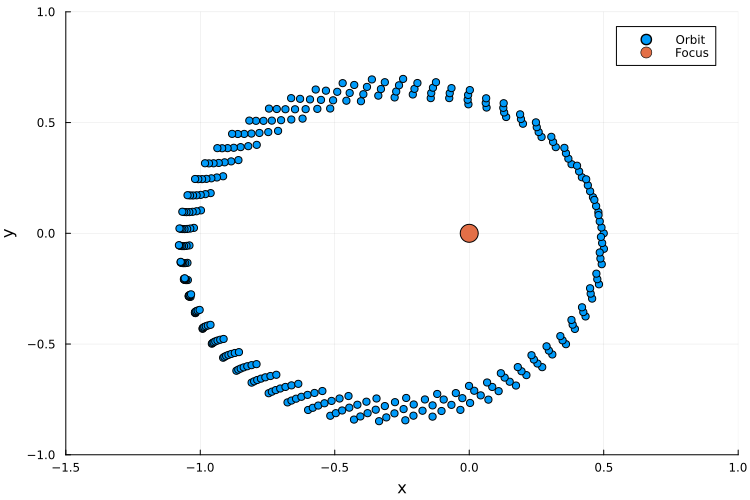

In [3]:
Euler([0.5, 0], [0, 1.63], 0.1, 300) # 初期位置(0.5, 0), 初速度(0, 1.63), 時間幅0.1, 繰り返し300

だいたい楕円軌道だが，はっきり誤差が見える．

## Feynmanの方法(Leap-frog法)

https://www.feynmanlectures.caltech.edu/I_09.html の9-5で，ファインマンは(9.16)式
$$\begin{aligned}
v(t+\Delta t /2) &= v(t-\Delta t /2) + a(t) \Delta t \\
r(t+\Delta t)&=r(t)+v(t+\Delta t/2)
\end{aligned}$$
のような計算を考えた．
この方法はLeap-frog法と呼ばれ，2次近似である．

In [4]:
function Feynman(r, v, Δt, i)
    x = [r[1]]
    y = [r[2]]
    a = -r / norm(r) ^ 3           # 初期の加速度a(0)を計算
    v += a * Δt / 2              # v(Δt/2)を計算

    for _ in 1:i
        
        r += v * Δt              # 位置をフルステップ更新，r(t+Δt) = r(t) + v(t+Δt/2) Δt
        a = -r / norm(r) ^ 3       # 新しい加速度を計算
        v += a * Δt              # 速度をフルステップ更新，v(t+Δt/2) = v(t-Δt/2) + a(t) Δt

        push!(x, r[1])
        push!(y, r[2])
    end

    #プロットする．
    plot = scatter(x, y, 
    xlabel = "x", ylabel = "y",
    size = (750, 500), label = "Orbit",
    xlims = (-1.5, 1), ylims = (-1, 1))
   
    scatter!(plot, [0], [0],
    markersize = 10, label = "Focus")
    
    return plot
end

Feynman (generic function with 1 method)

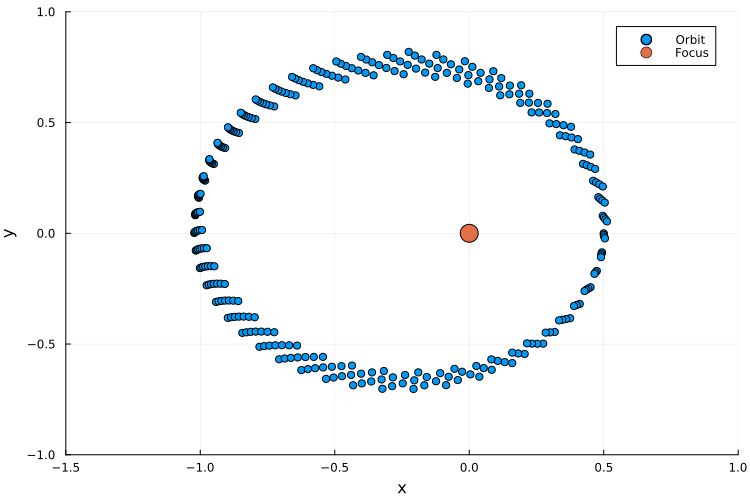

In [5]:
Feynman([0.5, 0], [0, 1.63], 0.1, 300) # 初期位置(0.5, 0), 初速度(0, 1.63), 時間幅0.1, 繰り返し300

あまり精度が上がった感じがしない......

## Runge-Kutta法

4次のRunge-Kutta法で精度を上げてみる．新たな関数を定義する．
詳細な式は https://drive.google.com/file/d/1BJzy3BMRnBzB0bVKxcA0ucTAcTFmnn0r/view?usp=sharing を参照．

In [6]:
function Runge_Kutta(r, v, Δt, i)
    x = [r[1]]
    y = [r[2]]
    h = [cross(r, v)]               # 後々のため角運動量に相当する量hを計算しておく

    for _ in 1:i
        a(r) = -r / norm(r) ^ 3
        
        
        r_p = r
        v_p = v
        k_r1 = v_p
        k_v1 = a(r_p)               #k_1を定義
        
        r_p = r + 0.5 * k_r1 * Δt
        v_p = v + 0.5 * k_v1 * Δt
        k_r2 = v_p
        k_v2 = a(r_p)               #k_2を定義
        
        r_p = r + 0.5 * k_r2 * Δt
        v_p = v + 0.5 * k_v2 * Δt
        k_r3 = v_p
        k_v3 = a(r_p)               #k_3を定義
        
        r_p = r + k_r3 * Δt
        v_p = v + k_v3 * Δt
        k_r4 = v_p
        k_v4 = a(r_p)               #k_4を定義
        
        r += (k_r1 + 2.0 * k_r2 + 2.0 * k_r3 + k_r4) * Δt / 6.0
        v += (k_v1 + 2.0 * k_v2 + 2.0 * k_v3 + k_v4) * Δt / 6.0
        

        push!(x, r[1])
        push!(y, r[2])
        push!(h, cross(r, v))

    end

    plot = scatter(x, y, 
    xlabel = "x", ylabel = "y",
    size = (750, 500), label = "Orbit",
    xlims = [-1.5, 1], ylims = [-1, 1],)
   
    scatter!(plot, [0], [0],
    marker = 10, label = "Focus")
    
    return plot, x, y, h                                            #後々のためx, y, hも返すようにしておく
end

plot_R, x, y, h = Runge_Kutta([0.5, 0, 0], [0, 1.63, 0], 0.1, 300)  #戻り値を割り当てる

(Plot{Plots.GRBackend() n=2}, [0.5, 0.480260648979387, 0.42394899078287285, 0.33846414386124357, 0.23289635982967655, 0.11570038807914258, -0.006363636951036311, -0.12833792471027095, -0.24676115851487346, -0.3592841635660347  …  -0.33596054104539175, -0.4428348087100069, -0.5413349471324802, -0.6307206981113096, -0.7105176855631095, -0.7804281769566731, -0.8402707369025759, -0.8899394365819818, -0.9293762806038367, -0.9585526311393171], [0.0, 0.1608469872799771, 0.30960556211041745, 0.4373547310076399, 0.5395594366831672, 0.6153651387927149, 0.6661863254629189, 0.6944994330290873, 0.7030892511042381, 0.6946635182398553  …  0.6957359757138061, 0.6753873590749092, 0.6421938988863429, 0.5981411425720715, 0.5449634146664384, 0.4841808052608164, 0.41713631992210587, 0.3450299054389089, 0.2689484742043235, 0.18989211252699223], [[0.0, 0.0, 0.815], [0.0, -0.0, 0.8149928010072492], [0.0, -0.0, 0.8149865909380112], [0.0, -0.0, 0.814982215016328], [0.0, -0.0, 0.8149795363313876], [0.0, -0.0, 0.

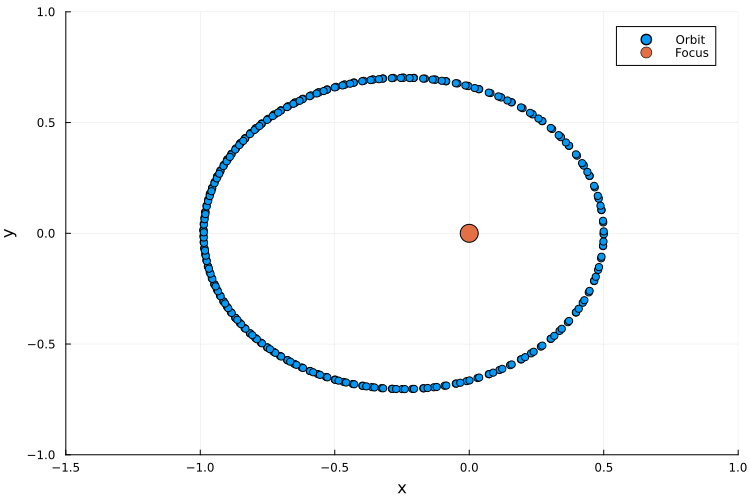

In [7]:
plot_R #Runge_Kutta([0.5, 0, 0], [0, 1.63, 0], 0.1, 300) をプロット

かなり精度が上がった！

## 3法則の確認

Keplerの3法則
- 楕円軌道の法則
- 面積速度一定の法則
- 調和の法則

が成り立っているか調べる．最も精度が高かったRunge-Kutta法で考える．

### 楕円軌道の法則

これは成立しているとしてよいだろう．後々のため，長半径と短半径を計算する．

In [8]:
L = (maximum(x) - minimum(x)) / 2 #長半径Lを計算
l = (maximum(y) - minimum(y)) / 2 #短半径lを計算

0.7032614044625268

### 面積速度一定の法則

面積速度にに相当する量である位置ベクトルと速度ベクトルの外積
$$
h = r \times v
$$
を各プロットに対して求め，そのz成分を記録する．

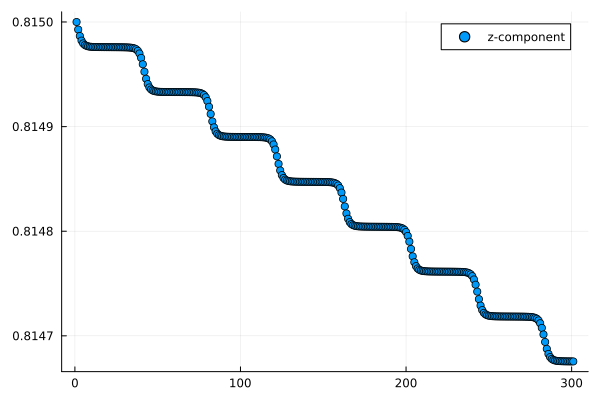

In [9]:
scatter(map(v -> v[3], h), label = "z-component")

ほぼ一定だが，だいたい40回のプロットごとに鋭く下降している．

### 調和の法則

Tを周期，Lを長半径とする．調和の法則によると，今回はGM = 1なので
$$
\frac{T^2}{L^3}=\frac{4\pi^2}{GM}=4\pi^2
$$
だった．Δt=0.1なので，n回のプロットで軌道を一周するとき
$$
T=n\Delta t=0.1n
$$
になる．上式に代入して
$$
n=10T=20\pi\sqrt{L^3}
$$
になる．右辺を計算する．


In [10]:
20*π*sqrt(L^3) #nを計算

40.347851172516016

惑星運動の周期を求めるために，y座標の符号変化を調べる．y座標が0以下から正に転じるとき，近日点を通過したといえる．

In [11]:
for i in 1:300
    if y[i] <= 0 && y[i+1] > 0 # 近日点を通過したとき，その時のy座標を表示
        println("y[", i, "] = ", y[i], " から y[", i+1, "] = ", y[i+1]," の間に近日点を通過")
    end
end

y[1] = 0.0 から y[2] = 0.1608469872799771 の間に近日点を通過
y[41] = -0.057847900978937716 から y[42] = 0.10445544592438408 の間に近日点を通過
y[81] = -0.1131309853671306 から y[82] = 0.0490456297943585 の間に近日点を通過
y[122] = -0.004799977881869838 から y[123] = 0.15620446625967324 の間に近日点を通過
y[162] = -0.056591898205404334 から y[163] = 0.10567267452117438 の間に近日点を通過
y[202] = -0.10594260803050923 から y[203] = 0.05631140794275638 の間に近日点を通過
y[242] = -0.15256751098451488 から y[243] = 0.008550394195253969 の間に近日点を通過
y[283] = -0.03725587842249817 から y[284] = 0.1246607949452663 の間に近日点を通過


だいたい40回のプロットで一周していることから，近似的に調和の法則が成り立っていると言える．

面積速度のグラフが40回ごとに鋭く減少したのは，近日点を通るとき
- 重力が大きい
- 曲率が大きい

という問題があるためかもしれない．